In [1]:
#citation for relative humidity calcs from WUSD3 data 
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
#https://vortex.plymouth.edu/~stmiller/stmiller_content/Publications/AtmosRH_Equations_Rev.pdf

In [2]:
import math
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from statsmodels.regression.linear_model import OLS
import matplotlib.dates as mdates
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor as MLP
from datetime import datetime, timedelta
import glob
import pytz
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

#### Reading All the Combined Meteo and Demand Files

Creates a dictionary of all the dataframes from the combined demand and meteo varibales for each BA

In [4]:
def read_files_to_dataframes(folder_path):
    # Find all files in the folder path provided. Assuming these are CSV files.
    file_pattern = os.path.join(folder_path, '*.csv')
    file_paths = glob.glob(file_pattern)
    
    # Dictionary to hold the data frames
    dataframes = {}

    # Loop over the list of filepaths & read each file into a separate dataframe
    for file_path in file_paths:
        # Extract the part of the filename before the first underscore
        base_name = os.path.basename(file_path)
        df_name = base_name.split('_')[0]
        
        # Read the file into a dataframe and store it in the dictionary with df_name as the key
        dataframes[df_name] = pd.read_csv(file_path)
        
    return dataframes

folder_path = "/nfs/turbo/seas-mtcraig-climate/Martha_Research/ERA5_Weighted_IncludingDemand"
dataframes_dict = read_files_to_dataframes(folder_path)

In [5]:
dataframes_dict.keys()

dict_keys(['SRP', 'TEPC', 'WACM', 'PSCO', 'PGE', 'PSEI', 'CISO', 'PACE', 'AZPS', 'LDWP', 'CPD', 'NEVP', 'SCL', 'MONT', 'nodemand', 'AVA', 'IPCO', 'WALC', 'EPE', 'BPAT', 'PNM', 'BANC', 'PACW'])

In [9]:
dataframes_dict['CISO'].to_csv('/nfs/turbo/seas-mtcraig/jmoraski/2019_demand/CISO.csv')

### Set up BA for Training and Prediction

You have to train and predict together because the normalization for each GCM is different and needs to be saved/used. 

#### Functions -- Process all the data into variable dataframe

In [5]:
def add_weekend_or_weekday_column(df, target_timezone):
    """
    add weekend information based on the target timezone while keep UTC in index
    """
    if df.index.tzinfo is None:
        df.index = df.index.tz_localize('UTC')  # tz-naive to UTC
    # target timezone
    tz = pytz.timezone(target_timezone)
    
    local_dates = df.index.tz_convert(tz).date  # Get the date

    # transfer local_dates to pandasSeries
    local_dates_series = pd.Series(local_dates, index=df.index)

    # Define weekend 1 or weekday 0
    df['Weekend'] = local_dates_series.apply(lambda x: 1 if x.weekday() >= 5 else 0)

    return df

  

In [6]:
def train_process(df,timezone):
    """
    Process the dataframe to what we need
    """
    # Set index as time
    if df.index.name == 'time': 
        pass 
    else:
        df['time'] = pd.to_datetime(df['time'])
        
        df.set_index('time', inplace=True)
    #this maps the months to a value 1-4 which represnts each season. 1 = winter (DJF), 2 = spring (MAM), 3 = summer (JJA), 4 = fall (SON) 
    month_to_season = { 12: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4}
    
    df = add_weekend_or_weekday_column(df, timezone)
    
    df['Season'] = df.index.month.map(month_to_season)
    #df['Weekend'] = (df.index.weekday >= 5).astype(int)
    df['Hour'] = df.index.hour.astype(int)
    df['Year'] = df.index.year.astype(int)

    #Pick cols for use
    cols = ['T (C)', 'Season','Weekend','Hour','cleaned demand (MW)'] # 'RH',
    df = df[cols]

    return df

#### Functions -- Machine learning model for demand regression

In [7]:
def metrics_test_data(y_test, model_y_pred):
    '''---Metrics (r-squared, MAE, MAPE)---'''
    r2= sklearn.metrics.r2_score(y_test, model_y_pred)
    print("R-squared:" ,r2)
    
    mae= sklearn.metrics.mean_absolute_error(y_test, model_y_pred)
    print("Mean absolute error:" ,mae)
    
    y_test, model_y_pred = np.array(y_test), np.array(model_y_pred)
    mape = np.mean(np.abs((y_test - model_y_pred)/y_test))*100
    print("Mean absolute Percentage error:" ,mape)

In [11]:
def MLP_prediction(df,start_check_date,end_check_date): #df is the input; check_date are used for check the peaks
    X_columns = ['T (C)',  'Season','Weekend','Hour'] #'RH',
    X = df[X_columns]

    y = df[['cleaned demand (MW)']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, test_size=0.2, random_state=123)

    #normalize x
    norm =MinMaxScaler().fit(X_train)
    X_train_norm=norm.transform(X_train)
    X_test_norm = norm.transform(X_test)
    #normalize y
    ynorm=MinMaxScaler().fit(y_train)
    y_train_norm=ynorm.transform(y_train)

    MLP_model = MLP(activation= 'relu', hidden_layer_sizes= (1452,), learning_rate= 'constant', max_iter= 100, solver= 'adam', random_state=42)
    MLP_score = cross_val_score(MLP_model, X_train_norm, y_train_norm, cv=5, scoring='r2')

    MLP_model.fit(X_train_norm,y_train_norm)
    '''Predicting the load using test data'''
    MLP_y_pred_norm = MLP_model.predict(X_test_norm).reshape(-1,1)
    MLP_y_pred = ynorm.inverse_transform(MLP_y_pred_norm)

    #Metrics on Prediction
    print("...................Metrics on test data..................")

    #Base case
    print("........Base Case Prediction.....")
    results_base=metrics_test_data(y_test, MLP_y_pred)

    #check with filter
    df_filter = df[start_check_date:end_check_date]
    X_df_filter = norm.transform(df_filter[X_columns])
    df_filter['predict_demand'] = ynorm.inverse_transform(MLP_model.predict(X_df_filter).reshape(-1,1))

    plt.figure(figsize=(10,5))
    plt.plot(df_filter['predict_demand'],label = 'predicted')
    plt.plot(df_filter['cleaned demand (MW)'],label = 'observed')
    plt.xlabel('Date')
    plt.ylabel('Demand in MW')
    plt.legend()
    


    return df_filter, MLP_model, norm, ynorm

### Functions -- MLP output to predict the future demand then!

In [12]:
def data_prediction(df,timezone, model, norm, ynorm, year):
    """
    Process the dataframe to what we need
    """
    #convert from K to C
    df['Temperature (K)'] = df['Temperature (K)'] - 273.15 
    df.rename(columns={'Temperature (K)': 'T (C)'}, inplace=True)
    #adjust times 
    time_index = pd.date_range(start=pd.to_datetime(f'{year}-09-01 00:00:00'), periods = len(temp_data), freq='h')
    df['time'] = time_index
    df = df.set_index('time') 

    # Set index as time
    if df.index.name == 'time': 
        pass 
    else:
        df['time'] = pd.to_datetime(df['time'])
        
        df.set_index('time', inplace=True)

    #e and es both in Pa, es formula multiplied by 100 to get there 
    df["e"] = ((df["Pressure (Pa)"] * df['Specific Humidity (kg/kg)'])/(0.622 + df['Specific Humidity (kg/kg)']*(1-0.622)))
    df["es"] = (6.11*(10**((7.5*df["T (C)"])/(273.5 + df["T (C)"]))))*100
    df["RH"] = df["e"]/df["es"]
    #this maps the months to a value 1-4 which represnts each season. 1 = winter (DJF), 2 = spring (MAM), 3 = summer (JJA), 4 = fall (SON) 
    month_to_season = { 12: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4}
    
    # Adding values for the categorical types to the dataframe  -- notes on this: the weekday/weekend is in adjusted timezone but the index remains the same
    df = add_weekend_or_weekday_column(df, timezone)
    
    df['Season'] = df.index.month.map(month_to_season)
    #df['Weekend'] = (df.index.weekday >= 5).astype(int)
    df['Hour'] = df.index.hour.astype(int) #this is in UTC hours 
    df['Year'] = df.index.year.astype(int)

    #Pick cols for use
    cols = ['T (C)', 'Season','Weekend','Hour'] # no 'RH', right now for EPE and WACM
    df = df[cols]
    
    #print(df)

    # Normalize the new input data
    X_norm = norm.transform(df)

    # Make predictions
    y_pred = model.predict(X_norm).reshape(-1, 1)

    # Inverse transform predictions to the original scale
    demand_pred = ynorm.inverse_transform(y_pred)

    #with time in dataframe
    demand = pd.DataFrame(index=time_index)
    demand['Demand (MW)'] = demand_pred


    return demand

### Execution 

...................Metrics on test data..................
........Base Case Prediction.....
R-squared: 0.9252363777987043
Mean absolute error: 53.97260413333691
Mean absolute Percentage error: 5.59818380591609
Finsihed EC3veg 2024 EPE
Finsihed EC3veg 2025 EPE
Finsihed EC3veg 2026 EPE
Finsihed EC3veg 2027 EPE
Finsihed EC3veg 2028 EPE
Finsihed EC3veg 2029 EPE
Finsihed EC3veg 2030 EPE
Finsihed EC3veg 2031 EPE
Finsihed EC3veg 2032 EPE
Finsihed EC3veg 2033 EPE
Finsihed EC3veg 2034 EPE
Finsihed EC3veg 2035 EPE
Finsihed EC3veg 2036 EPE
Finsihed EC3veg 2037 EPE
Finsihed EC3veg 2038 EPE
Finsihed EC3veg 2039 EPE
Finsihed EC3veg 2040 EPE
Finsihed EC3veg 2041 EPE
Finsihed EC3veg 2042 EPE
Finsihed EC3veg 2043 EPE
Finsihed EC3veg 2044 EPE
Finsihed EC3veg 2045 EPE
Finsihed EC3veg 2046 EPE
Finsihed EC3veg 2047 EPE
Finsihed EC3veg 2048 EPE
Finsihed EC3veg 2049 EPE
Finsihed EC3veg 2050 EPE
Finsihed EC3veg 2051 EPE
Finsihed EC3veg 2052 EPE
Finsihed EC3veg 2053 EPE
Finsihed EC3veg 2054 EPE
Finsihed EC3veg

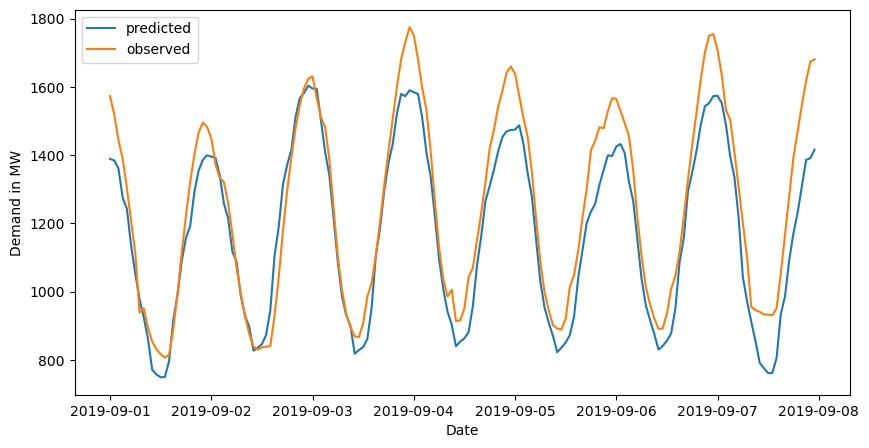

In [14]:
#ba list based on timezone 
#'CISO', 'LDWP',
ba_LA = ['CISO', 'LDWP']#['AVA', 'BANC', 'BPAT', 'CPD', 'NEVP', 'PACW', 'PGE','PSEI', 'SCL'] #LA timezone 
ba_DEN = ['WACM', 'EPE', 'IPCO', 'MONT', 'PACE', 'PNM', 'PSCO',] 
ba_AZ = ['WALC', 'AZPS', 'SRP','WALC', 'TEPC']
gcm_list = ['EC3veg','EC3', 'MPI', 'TAI', 'MIROC6']

for ba in ["EPE"]: 
    timezone = 'America/Denver' #America/Denver #US/Arizona 
    #training execution 
    train_process(dataframes_dict[ba], timezone)
    df = train_process(dataframes_dict[ba],timezone)
    df_filter, MLP_model, norm, ynorm = MLP_prediction(df,'2019-09-01','2019-09-07')
    for gcm in gcm_list: 
        for year in range(2024, 2064):
            #load in future population weighted data 
            temp_data = pd.read_csv(f'/nfs/turbo/seas-mtcraig-climate/WRFDownscaled/Population_Weighted_Data/{gcm}_wrf_output/{ba}-{year}-pop-weighted-temperature.csv')
            q2_data = pd.read_csv(f"/nfs/turbo/seas-mtcraig-climate/WRFDownscaled/Population_Weighted_Data/{gcm}_Q2_wrf_output/{ba}-{year}-pop-weighted-sh.csv", usecols=[1]) #column 1 to use values not dates
            q2_data.columns = ['Specific Humidity (kg/kg)']
            # Replace 0s in the 'Specific Humidity (kg/kg)' column with 0.0000001
            q2_data['Specific Humidity (kg/kg)'] = q2_data['Specific Humidity (kg/kg)'].replace(0, 0.0000001)
            psfc_data = pd.read_csv(f"/nfs/turbo/seas-mtcraig-climate/WRFDownscaled/Population_Weighted_Data/{gcm}_PSFC_wrf_output/{ba}-{year}-pop-weighted-pressure.csv", usecols = [1])
            psfc_data = psfc_data.fillna(method='ffill')#Nans in 2027 ec3 pressure just last day of the year -- unknown reason 
            psfc_data.columns = ['Pressure (Pa)']
            future_weather_data = pd.concat([temp_data, q2_data, psfc_data], axis=1)

            #predict 
            df =  data_prediction(future_weather_data,timezone, MLP_model, norm,  ynorm, year)

            #save 
            df.to_csv(f'/nfs/turbo/seas-mtcraig-climate/Martha_Research/WRF_Data/MLPAlgorithm/{gcm.upper()}_Demand/{ba}_{year}_demand.csv')

            print(f'Finsihed {gcm} {year} {ba}')

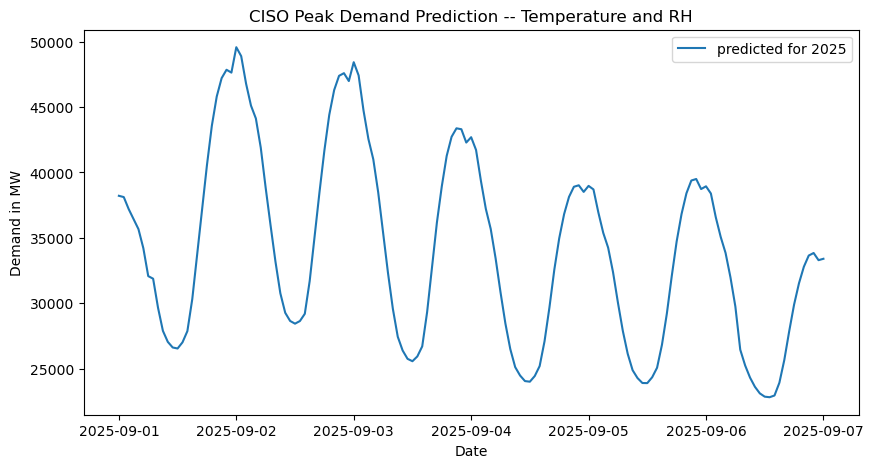

In [22]:
plt.figure(figsize=(10,5))
df = df[np.datetime64('2025-09-01'):np.datetime64('2025-09-07')]
plt.plot(df['Demand (MW)'],label = 'predicted for 2025')
plt.xlabel('Date')
plt.ylabel('Demand in MW')
plt.title('CISO Peak Demand Prediction -- Temperature and RH') 
plt.legend()

### Saving Metrics by BA 

In [16]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as MLP
import matplotlib.pyplot as plt


def metrics_test_data(y_test, model_y_pred):
    '''---Metrics (r-squared, MAE, MAPE)---'''
    r2 = sklearn.metrics.r2_score(y_test, model_y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_test, model_y_pred)
    y_test, model_y_pred = np.array(y_test), np.array(model_y_pred)
    mape = np.mean(np.abs((y_test - model_y_pred) / y_test)) * 100
    return {'R2': r2, 'MAE': mae, 'MAPE': mape}
def MLP_prediction(df, start_check_date, end_check_date):
    X_columns = ['T (C)', 'RH', 'Season', 'Weekend', 'Hour']
    X = df[X_columns]
    y = df[['cleaned demand (MW)']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
    norm = MinMaxScaler().fit(X_train)
    X_train_norm = norm.transform(X_train)
    X_test_norm = norm.transform(X_test)
    ynorm = MinMaxScaler().fit(y_train)
    y_train_norm = ynorm.transform(y_train)
    MLP_model = MLP(activation='relu', hidden_layer_sizes=(1452,), learning_rate='constant', max_iter=100, solver='adam', random_state=42)
    MLP_model.fit(X_train_norm, y_train_norm)
    MLP_y_pred_norm = MLP_model.predict(X_test_norm).reshape(-1, 1)
    MLP_y_pred = ynorm.inverse_transform(MLP_y_pred_norm)

    # Collect metrics
    results_base = metrics_test_data(y_test, MLP_y_pred)

    # Predict within the specified date range
    df_filter = df.loc[start_check_date:end_check_date]
    X_df_filter = norm.transform(df_filter[X_columns])
    df_filter['predict_demand'] = ynorm.inverse_transform(MLP_model.predict(X_df_filter).reshape(-1, 1))

    return df_filter, MLP_model, norm, ynorm, results_base

# List of balancing authorities by timezone
ba_LA = ['CISO', 'LDWP', 'AVA', 'BANC', 'BPAT', 'CPD', 'NEVP', 'PACW', 'PGE', 'PSEI', 'SCL']
ba_DEN = ['WACM', 'EPE', 'IPCO', 'MONT', 'PACE', 'PNM', 'PSCO']
ba_AZ = ['WALC', 'AZPS', 'SRP', 'WALC', 'TEPC']

# Dictionary to store metrics for each balancing authority
metrics_dict = {}

# Assuming `dataframes_dict` contains the dataframes for each BA
all_bas = ba_LA + ba_DEN + ba_AZ

for ba in all_bas:
    # Determine the timezone based on the balancing authority
    if ba in ba_LA:
        timezone = 'America/Los_Angeles'
    elif ba in ba_DEN:
        timezone = 'America/Denver'
    elif ba in ba_AZ:
        timezone = 'US/Arizona'
    
    print(f"Processing Balancing Authority: {ba} with timezone {timezone}")

    # Assuming train_process handles preprocessing, including timezone adjustments
    df = train_process(dataframes_dict[ba], timezone)

    df_filter, MLP_model, norm, ynorm, results_base = MLP_prediction(df, '2019-09-01', '2019-09-07')
    metrics_dict[ba] = results_base
    print(f"Metrics for {ba}: {results_base}")

# Convert metrics dictionary to DataFrame for easier analysis/visualization
metrics_df = pd.DataFrame(metrics_dict).T
print(metrics_df)

Processing Balancing Authority: CISO with timezone America/Los_Angeles
Metrics for CISO: {'R2': 0.9161877343735099, 'MAE': 1140.550963639018, 'MAPE': 4.492051912469344}
Processing Balancing Authority: LDWP with timezone America/Los_Angeles
Metrics for LDWP: {'R2': 0.9128111816566485, 'MAE': 162.6493735245768, 'MAPE': 5.197240469042956}
Processing Balancing Authority: AVA with timezone America/Los_Angeles
Metrics for AVA: {'R2': 0.8952269430063317, 'MAE': 68.92350430463371, 'MAPE': 5.233510829623308}
Processing Balancing Authority: BANC with timezone America/Los_Angeles
Metrics for BANC: {'R2': 0.9352711026823342, 'MAE': 99.15630853545265, 'MAPE': 4.844514005670009}
Processing Balancing Authority: BPAT with timezone America/Los_Angeles
Metrics for BPAT: {'R2': 0.933917665137581, 'MAE': 208.72684204694417, 'MAPE': 3.0495304593319226}
Processing Balancing Authority: CPD with timezone America/Los_Angeles
Metrics for CPD: {'R2': 0.7610823358905624, 'MAE': 61.979753717103826, 'MAPE': 6.36752

In [17]:
metrics_df 

,R2,MAE,MAPE
CISO,0.916188,1140.550964,4.492052
LDWP,0.912811,162.649374,5.197240
AVA,0.895227,68.923504,5.233511
BANC,0.935271,99.156309,4.844514
BPAT,0.933918,208.726842,3.049530
CPD,0.761082,61.979754,6.367526
NEVP,0.937649,195.021096,4.528695
PACW,0.862898,120.642487,5.569358
PGE,0.937033,79.875438,3.429190
PSEI,0.902365,154.628982,4.828962


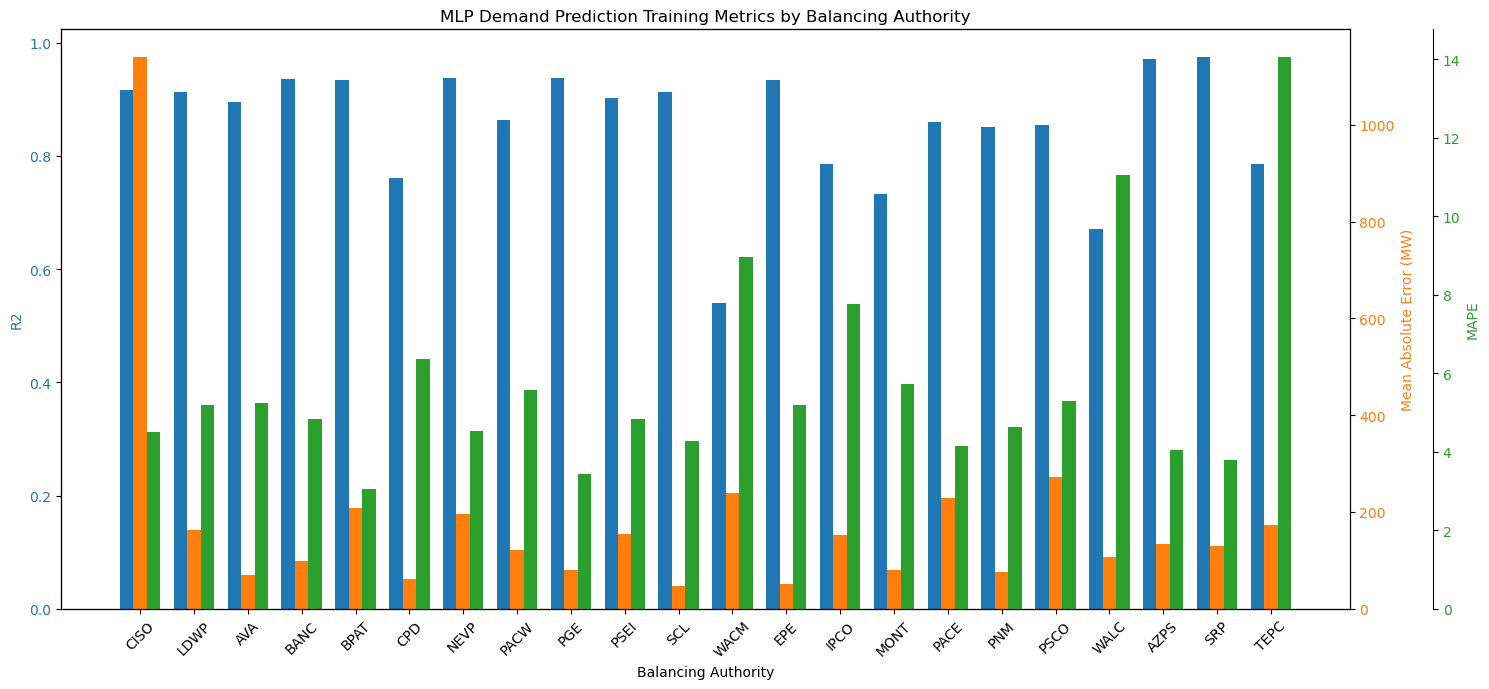

In [20]:
# Set the width for the bars
bar_width = 0.25

# Calculate positions for each group's bars
r1 = np.arange(len(metrics_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting using matplotlib
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot R2 with the first y-axis
ax1.set_xlabel('Balancing Authority')
ax1.set_ylabel('R2', color='tab:blue')
ax1.bar(r1, metrics_df['R2'], color='tab:blue', width=bar_width, label='R2')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks([r + bar_width for r in range(len(metrics_df))])
ax1.set_xticklabels(metrics_df.index, rotation=45)

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Absolute Error (MW)', color='tab:orange')
ax2.bar(r2, metrics_df['MAE'], color='tab:orange', width=bar_width, label='MAE')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Create a third y-axis for MAPE
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.set_ylabel('MAPE', color='tab:green')
ax3.bar(r3, metrics_df['MAPE'], color='tab:green', width=bar_width, label='Mean Absolute Percentage Error')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Title and layout adjustments
plt.title('MLP Demand Prediction Training Metrics by Balancing Authority')
fig.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [33]:
hourly_demand = pd.read_csv(f'/nfs/turbo/seas-mtcraig-climate/Martha_Research/WRF_Data/MLPAlgorithm/{gcm.upper()}_Demand/{ba}_{year}_demand.csv')
# Rename the 'Unnamed: 0' column to 'time'
hourly_demand = hourly_demand.rename(columns={'Unnamed: 0': 'time'})

In [34]:
hourly_demand

,time,Demand (MW)
0,2025-09-01 00:00:00,2350.250519
1,2025-09-01 01:00:00,2355.753949
2,2025-09-01 02:00:00,2347.150562
3,2025-09-01 03:00:00,2350.159656
4,2025-09-01 04:00:00,2238.383367
...,...,...
8780,2026-09-01 20:00:00,1860.303338
8781,2026-09-01 21:00:00,1964.378954
8782,2026-09-01 22:00:00,2038.043357
8783,2026-09-01 23:00:00,2093.644250


In [35]:
hourly_demand['time'] = pd.to_datetime(hourly_demand['time'])  # Ensure 'time' is in datetime format
hourly_demand = hourly_demand.set_index('time')
hourly_demand_xr = hourly_demand.to_xarray().rename({'Demand (MW)': ba})  # Rename for easier summation

In [36]:
hourly_demand_xr

<xarray.Dataset> Size: 141kB
Dimensions:  (time: 8785)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2025-09-01 ... 2026-09-02
Data variables:
    TEPC     (time) float64 70kB 2.35e+03 2.356e+03 ... 2.094e+03 2.002e+03